In [1]:
import numpy as np
import torch
import importlib
import matplotlib.pyplot as plt
%matplotlib inline

# Simple example

Import the simple_example module, reloading it so we are sure to get any changes.

In [2]:
import simple_example
importlib.reload(simple_example)

<module 'simple_example' from '/Users/timothybretl/Documents/courses/598RL/02_Fall2020/598rl-fa20/lecture_notes/12_policygradient/simple_example.py'>

Create a random number generator and an instance of the simple_example environment.

In [3]:
rg = np.random.default_rng()
env = simple_example.SimpleExample(rg=rg)

Run simulator to create a trajectory and compute the total reward.

In [4]:
s = env.reset()
data = {
    's': [s],
    'a': [],
    'r': [],
}
done = False
while not done:
    a = rg.integers(env.num_actions)
    s, r, done = env.step(a)
    data['s'].append(s)
    data['a'].append(a)
    data['r'].append(r)

print(f'The number of time steps is:')
print(f' len(data["a"]) = {len(data["a"])}')
print(f' env.max_num_steps = {env.max_num_steps}')

print('')

print(f'The trajectory is:')
print(f' tau = (s0, a0, s1, a1)')
print(f'     = ({data["s"][0]:2d}, {data["a"][0]:2d}, {data["s"][1]:2d}, {data["a"][1]:2d})')

print('')

print(f'The total reward is:')
print(f' r(tau) = r(s0, a0) + r(s1, a1)')
print(f'        = {data["r"][0]} + {data["r"][1]}')
print(f'        = {data["r"][0] + data["r"][1]}')

The number of time steps is:
 len(data["a"]) = 2
 env.max_num_steps = 2

The trajectory is:
 tau = (s0, a0, s1, a1)
     = ( 1,  1,  1,  0)

The total reward is:
 r(tau) = r(s0, a0) + r(s1, a1)
        = 0 + 0
        = 0


## World model

Probability that the initial state is $s_0$

In [5]:
for s0 in [0, 1]:
    print(f'p(s0 = {s0}) = {env.p0(0)}')

p(s0 = 0) = 0.5
p(s0 = 1) = 0.5


Conditional probability that the next state is $s_{t+1}$ given that the state is $s_t$ and that the agent takes action $a_t$

In [6]:
for s in [0, 1]:
    for a in [0, 1]:
        for s_next in [0, 1]:
            print(f'p(s_{{t+1}} = {s_next} | s_t = {s}, a_t = {a}) = {env.p(s_next, s, a)}')

p(s_{t+1} = 0 | s_t = 0, a_t = 0) = 0.8
p(s_{t+1} = 1 | s_t = 0, a_t = 0) = 0.2
p(s_{t+1} = 0 | s_t = 0, a_t = 1) = 0.2
p(s_{t+1} = 1 | s_t = 0, a_t = 1) = 0.8
p(s_{t+1} = 0 | s_t = 1, a_t = 0) = 0.2
p(s_{t+1} = 1 | s_t = 1, a_t = 0) = 0.8
p(s_{t+1} = 0 | s_t = 1, a_t = 1) = 0.8
p(s_{t+1} = 1 | s_t = 1, a_t = 1) = 0.2


Mean reward for taking action $a_t$ at state $s_t$

In [7]:
for s in [0, 1]:
    for a in [0, 1]:
        print(f'r(s_t = {s}, a_t = {a}) = {env.r(s, a)}')

r(s_t = 0, a_t = 0) = 8.0
r(s_t = 0, a_t = 1) = 2.0
r(s_t = 1, a_t = 0) = 2.0
r(s_t = 1, a_t = 1) = 8.0


## Agent model

"Softmax" is a common choice for a tabular policy, given a finite state and action space

In [8]:
def action_probability(a, s, theta):
    return np.exp(theta[s, a]) / np.exp(theta[s]).sum()

Conditional probability that the agent takes action $a_t$ at state $s_t$ for a particular choice of $\theta$

In [9]:
# Sample weights from a normal distribution
theta = rg.standard_normal(size=(2, 2))
# # Choose all weights to be zero
# theta = np.zeros((2, 2))
print(f'theta = {theta.tolist()}')
print('')
for s in [0, 1]:
    for a in [0, 1]:
        print(f'p(a_t = {a} | s_t = {s}; theta) = {action_probability(a, s, theta)}')

theta = [[1.6911673689820172, -1.4772185295440334], [0.16878339988127788, 1.1083159791492774]]

p(a_t = 0 | s_t = 0; theta) = 0.9596270959254751
p(a_t = 1 | s_t = 0; theta) = 0.040372904074524874
p(a_t = 0 | s_t = 1; theta) = 0.2809947690620148
p(a_t = 1 | s_t = 1; theta) = 0.7190052309379853


Returns an action $a$ at state $s$ according to our tabular policy

In [10]:
def action(s, theta):
    p = [action_probability(a, s, theta) for a in range(env.num_actions)]
    a = rg.choice(range(env.num_actions), p=p)
    return a

Remember that our policy is stochastic - actions are being *sampled* from a weighted distribution

In [11]:
print(f'ten actions sampled at state 0: {[action(0, theta) for i in range(10)]}')
print(f'ten actions sampled at state 1: {[action(1, theta) for i in range(10)]}')

ten actions sampled at state 0: [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
ten actions sampled at state 1: [1, 0, 1, 1, 0, 0, 1, 0, 1, 0]


## Payoff gradient (exact)

Gradient of action probability (i.e., of policy) with respect to $\theta$, computed by autodifferentiation

In [12]:
def action_probability_gradient(a, s, theta):
    # Convert theta to a torch tensor. Notes:
    # - torch.tensor always makes a copy (https://pytorch.org/docs/stable/generated/torch.tensor.html#torch.tensor)
    # - we must override the default value of requires_grad to take a gradient with respect to theta
    theta_t = torch.tensor(theta, requires_grad=True)
    p_t = torch.exp(theta_t[s, a]) / torch.exp(theta_t[s]).sum()
    p_t.backward()
    return theta_t.grad.numpy()

Choose $\theta$ for example

In [13]:
theta = np.array([[3., -1.], [2., 1.]])

Choose $\tau$ for example

In [14]:
s0, a0, s1, a1 = rg.integers(2, size=(4,))
print(f'tau = {s0, a0, s1, a1}')

tau = (1, 1, 0, 1)


Compute gradient of action probabilities along trajectory (which entries will be positive, negative, zero?)

In [15]:
print(f'grad p(a0 = {a0} | s0 = {s0} ; theta) = {action_probability_gradient(a0, s0, theta).tolist()}')
print(f'grad p(a1 = {a1} | s0 = {s1} ; theta) = {action_probability_gradient(a1, s1, theta).tolist()}')

grad p(a0 = 1 | s0 = 1 ; theta) = [[0.0, 0.0], [-0.19661193324148188, 0.19661193324148185]]
grad p(a1 = 1 | s0 = 0 ; theta) = [[-0.017662706213291118, 0.017662706213291118], [0.0, 0.0]]


We could recompute gradient of action probabilities by hand and check that they are the same...

Gradient of trajectory probability with respect to $\theta$

In [16]:
def trajectory_probability_gradient(s0, a0, s1, a1, theta):
    return env.p0(s0) * action_probability_gradient(a0, s0, theta) * env.p(s1, s0, a0) * action_probability(a1, s1, theta) + env.p0(s0) * action_probability(a0, s0, theta) * env.p(s1, s0, a0) * action_probability_gradient(a1, s1, theta)

Evaluate gradient of trajectory probability with respect to $\theta$, for one trajectory

In [17]:
print(f'theta = {theta.tolist()}')
for s in [0, 1]:
    for a in [0, 1]:
        print(f'p(a_t = {a} | s_t = {s}; theta) = {action_probability(a, s, theta)}')
print(f'tau = ({s0, a0, s1, a1})')
print(f'grad p(tau ; theta) = {trajectory_probability_gradient(s0, a0, s1, a1, theta).tolist()}')

theta = [[3.0, -1.0], [2.0, 1.0]]
p(a_t = 0 | s_t = 0; theta) = 0.9820137900379085
p(a_t = 1 | s_t = 0; theta) = 0.01798620996209156
p(a_t = 0 | s_t = 1; theta) = 0.7310585786300049
p(a_t = 1 | s_t = 1; theta) = 0.2689414213699951
tau = ((1, 1, 0, 1))
grad p(tau ; theta) = [[-0.0019000933256972628, 0.0019000933256972628], [-0.0014145214049336087, 0.0014145214049336087]]


Trajectory probability

In [18]:
def trajectory_probability(s0, a0, s1, a1, theta):
    return env.p0(s0) * action_probability(a0, s0, theta) * env.p(s1, s0, a0) * action_probability(a1, s1, theta)

If we move theta a small amount in the direction of the trajectory probability gradient, then we increase the trajectory probability

In [19]:
print(f'theta = {theta.tolist()}')
for s in [0, 1]:
    for a in [0, 1]:
        print(f'p(a_t = {a} | s_t = {s}; theta) = {action_probability(a, s, theta)}')
print(f'tau = ({s0, a0, s1, a1})')
print(f'p(tau ; theta) = {trajectory_probability(s0, a0, s1, a1, theta)}')
print(f'grad p(tau ; theta) = {trajectory_probability_gradient(s0, a0, s1, a1, theta).tolist()}')

print('')

theta += 1.0 * trajectory_probability_gradient(s0, a0, s1, a1, theta)
print(f'theta = {theta.tolist()}')
for s in [0, 1]:
    for a in [0, 1]:
        print(f'p(a_t = {a} | s_t = {s}; theta) = {action_probability(a, s, theta)}')
print(f'tau = ({s0, a0, s1, a1})')
print(f'p(tau ; theta) = {trajectory_probability(s0, a0, s1, a1, theta)}')
print(f'grad p(tau ; theta) = {trajectory_probability_gradient(s0, a0, s1, a1, theta).tolist()}')

theta = [[3.0, -1.0], [2.0, 1.0]]
p(a_t = 0 | s_t = 0; theta) = 0.9820137900379085
p(a_t = 1 | s_t = 0; theta) = 0.01798620996209156
p(a_t = 0 | s_t = 1; theta) = 0.7310585786300049
p(a_t = 1 | s_t = 1; theta) = 0.2689414213699951
tau = ((1, 1, 0, 1))
p(tau ; theta) = 0.001934894748905628
grad p(tau ; theta) = [[-0.0019000933256972628, 0.0019000933256972628], [-0.0014145214049336087, 0.0014145214049336087]]

theta = [[2.9980999066743026, -0.9980999066743027], [1.9985854785950663, 1.0014145214049337]]
p(a_t = 0 | s_t = 0; theta) = 0.9819465453635355
p(a_t = 1 | s_t = 0; theta) = 0.018053454636464374
p(a_t = 0 | s_t = 1; theta) = 0.7305019915983424
p(a_t = 1 | s_t = 1; theta) = 0.2694980084016577
tau = ((1, 1, 0, 1))
p(tau ; theta) = 0.001946148027718729
grad p(tau ; theta) = [[-0.0019110133325844646, 0.001911013332584465], [-0.0014216650101937173, 0.0014216650101937173]]


Total reward for a trajectory

In [20]:
def total_reward(s0, a0, s1, a1):
    return env.r(s0, a0) + env.r(s1, a1)

Gradient of payoff with respect to $\theta$

In [21]:
def payoff_gradient(theta):
    # initialize gradient to zero
    grad = np.zeros_like(theta)
    
    # increment gradient by iterating over all trajectories
    for s0 in [0, 1]:
        for a0 in [0, 1]:
            for s1 in [0, 1]:
                for a1 in [0, 1]:
                    grad += total_reward(s0, a0, s1, a1) * trajectory_probability_gradient(s0, a0, s1, a1, theta)
    
    # return the result
    return grad

Evaluate gradient of payoff with respect to $\theta$

In [22]:
print(f'grad J(theta) = {payoff_gradient(theta).tolist()}')

grad J(theta) = [[0.13712255861177103, -0.13712255861177008], [-1.3445761594013481, 1.3445761594013474]]


Payoff

In [23]:
def payoff(theta):
    J = 0
    for s0 in [0, 1]:
        for a0 in [0, 1]:
            for s1 in [0, 1]:
                for a1 in [0, 1]:
                    J += total_reward(s0, a0, s1, a1) * trajectory_probability(s0, a0, s1, a1, theta)
    return J

Take a gradient ascent step - does the payoff increase? (Always? By how much? What about for other choices of $\alpha > 0$?)

In [24]:
print(f'payoff(theta_k) = {payoff(theta)}')
alpha = 0.1
theta += alpha * payoff_gradient(theta)
print(f'payoff(theta_{{k+1}}) = {payoff(theta)}')

payoff(theta_k) = 11.831121670613841
payoff(theta_{k+1}) = 12.21218534645647


If we wanted, we could use pytorch to compute the payoff gradient by autodifferentation all at once...

Take many gradient ascent steps - run "exact policy gradient method" to convergence

In [25]:
# Sample initial choice of weights
theta = rg.standard_normal(size=(2, 2))

# Define learning rate
alpha = 0.1

# Display initial policy
for s in [0, 1]:
    for a in [0, 1]:
        print(f'p(a_t = {a} | s_t = {s}; theta) = {action_probability(a, s, theta)}')

# Display initial payoff
print(f'initial payoff = {payoff(theta)}')

# Iterate to convergence
iters = 0
while True:
    iters += 1
    
    # Store old weights
#     theta_old = theta # <--- CAREFUL
    theta_old = theta.copy()
    
    # Update weights
#     theta = theta + alpha * payoff_gradient(theta) # <--- CAREFUL
    theta += alpha * payoff_gradient(theta)
    
    # Break if no weight changed by more than some threshold
    if np.max(np.abs(theta - theta_old)) < 1e-2:
        break

# Display number of iterations
print('')
print(f'iterations: {iters}')
print('')

# Display final policy
for s in [0, 1]:
    for a in [0, 1]:
        print(f'p(a_t = {a} | s_t = {s}; theta) = {action_probability(a, s, theta)}')

# Display final payoff
print(f'final payoff = {payoff(theta)}')

p(a_t = 0 | s_t = 0; theta) = 0.5008429491354449
p(a_t = 1 | s_t = 0; theta) = 0.4991570508645552
p(a_t = 0 | s_t = 1; theta) = 0.5868352302177604
p(a_t = 1 | s_t = 1; theta) = 0.4131647697822397
initial payoff = 9.470474949547402

iterations: 56

p(a_t = 0 | s_t = 0; theta) = 0.9873602726764698
p(a_t = 1 | s_t = 0; theta) = 0.012639727323530255
p(a_t = 0 | s_t = 1; theta) = 0.022604598232003604
p(a_t = 1 | s_t = 1; theta) = 0.9773954017679964
final payoff = 15.805838645024101


## Payoff gradient (exact with log probabilities)

Redefine gradients in terms of log probabilities

In [26]:
def action_log_probability(a, s, theta):
    return theta[s, a] - np.log(np.exp(theta[s]).sum())

def action_log_probability_gradient(a, s, theta):
    theta_t = torch.tensor(theta, requires_grad=True)
    p_t = theta_t[s, a] - torch.exp(theta_t[s]).sum().log()
    p_t.backward()
    return theta_t.grad.numpy()

def trajectory_log_probability_gradient(s0, a0, s1, a1, theta):
    return action_log_probability_gradient(a0, s0, theta) + action_log_probability_gradient(a1, s1, theta)

def payoff_gradient_with_log(theta):
    grad = 0
    for s0 in [0, 1]:
        for a0 in [0, 1]:
            for s1 in [0, 1]:
                for a1 in [0, 1]:
                    grad += trajectory_probability(s0, a0, s1, a1, theta) * trajectory_log_probability_gradient(s0, a0, s1, a1, theta) * total_reward(s0, a0, s1, a1)
    return grad

Check that exact payoff gradient is the same as before

In [27]:
theta = rg.standard_normal(size=(env.num_states, env.num_actions))
print(f'theta = {theta.tolist()}')
print(f'payoff = {payoff(theta)}')
print(f'payoff_gradient = {payoff_gradient(theta).tolist()}')
print(f'payoff_gradient_with_log = {payoff_gradient_with_log(theta).tolist()}')

theta = [[0.615560863271868, -1.3561695928868978], [0.08369029469261238, -0.7217757477709947]]
payoff = 11.311077148030588
payoff_gradient = [[0.7895111298303884, -0.7895111298303864], [-1.427674987788996, 1.427674987788996]]
payoff_gradient_with_log = [[0.7895111298303862, -0.7895111298303865], [-1.427674987788997, 1.427674987788996]]


If we wanted to, we could re-run exact policy gradient method to convergence, with log probabilities (just to check that everything still works - results should be the same as before)...

## Payoff gradient (estimates, with log probabilities)

Compare different ways of computing payoff gradient with estimate. How many trajectories do we need to sample? (Vary the choice of $N$.)

In [29]:
# Parameters as numpy array
theta = rg.standard_normal(size=(env.num_states, env.num_actions))

# Sampled trajectories
batch_s = []
batch_a = []
batch_w = []
N = 32
grad = np.zeros_like(theta)
for i in range(N):
    traj_s = []
    traj_a = []
    traj_r = []
    s = env.reset()
    while True:
        a = action(s, theta)
        s_prime, r, done = env.step(a)
        traj_s.append(s)
        traj_a.append(a)
        traj_r.append(r)
        s = s_prime
        if done:
            break
    grad += trajectory_log_probability_gradient(traj_s[0], traj_a[0], traj_s[1], traj_a[1], theta) * np.sum(traj_r)
    batch_s.extend(traj_s)
    batch_a.extend(traj_a)
    batch_w.extend([np.sum(traj_r)] * len(traj_r))
grad /= N
# print(f' batch:\n  s = {batch_s}\n  a = {batch_a}\n  w = {batch_w}')

# Gradient (exact)
print(f'\n grad payoff:\n    exact = {payoff_gradient_with_log(theta).tolist()}')

# Gradient (numpy, per trajectory)
print(f'\n grad payoff:\n  by traj = {grad.tolist()}')

g1 = np.reshape(payoff_gradient_with_log(theta), (-1,))
g2 = np.reshape(grad, (-1,))
print(f'  dot(exact, estimate) = {np.dot(g1, g2)}')

# Gradient (numpy, per state transition)
grad = np.zeros_like(theta)
for a, s, w in zip(batch_a, batch_s, batch_w):
    grad += action_log_probability_gradient(a, s, theta) * w
grad /= N
print(f'  by actn = {grad.tolist()}')

# Gradient (torch)
theta_t = torch.tensor(theta, requires_grad=True)
batch_s_t = torch.tensor(batch_s, requires_grad=False)
batch_a_t = torch.tensor(batch_a, requires_grad=False)
batch_w_t = torch.tensor(batch_w, requires_grad=False)
logits = theta_t[batch_s_t]
dist = torch.distributions.categorical.Categorical(logits=logits)
loss = (env.max_num_steps * dist.log_prob(batch_a_t) * batch_w_t).mean() # <-- "env.max_num_steps *" ??? WHY ???
loss.backward()
print(f'  by auto = {theta_t.grad.numpy().tolist()}')


 grad payoff:
    exact = [[0.5128846099768486, -0.5128846099768486], [-0.6337310782438802, 0.6337310782438796]]

 grad payoff:
  by traj = [[-0.39961248157384155, 0.39961248157384155], [-0.7558838838707946, 0.7558838838707937]]
  dot(exact, estimate) = 0.5481440339974596
  by actn = [[-0.39961248157384166, 0.39961248157384166], [-0.7558838838707951, 0.7558838838707936]]
  by auto = [[-0.39961248157384166, 0.399612481573842], [-0.7558838838707951, 0.7558838838707951]]


Define functions that will help us implement and visualize the results of a policy gradient method with estimated gradients that are computed using autodifferentiation

In [30]:
def action_greedy(s, theta):
    return theta[s].argmax()

def policy_as_string(theta):
    output = 'greedy policy:\n'
    for s in range(env.num_states):
        output += f' pi({s}) = {action_greedy(s, theta)}\n'
    return output
        
def plot_learning_curve(data):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.plot(data['step'], data['total_reward'], linewidth=2, label='total undiscounted reward')
    ax.grid()
    ax.set_ylim(0, 20)
    ax.legend(fontsize=14)
    ax.tick_params(labelsize=14)
    ax.set_xlabel('simulation steps', fontsize=20)
    plt.tight_layout()

Implementation without an optimizer (descent implemented by hand)


theta = [[-1.2918559438771895, 1.003777302767973], [0.7668311929212991, 2.5364049151287587]]

640 : 10.3125
1280 : 14.0625
1920 : 15.0
2560 : 14.6875
3200 : 17.5
3840 : 14.0625
4480 : 15.625
5120 : 16.25
5760 : 17.1875
6400 : 15.0

theta = [[2.289036896543053, -2.577115537652268], [-0.3602379328731829, 3.6634740409232407]]

greedy policy:
 pi(0) = 0
 pi(1) = 1



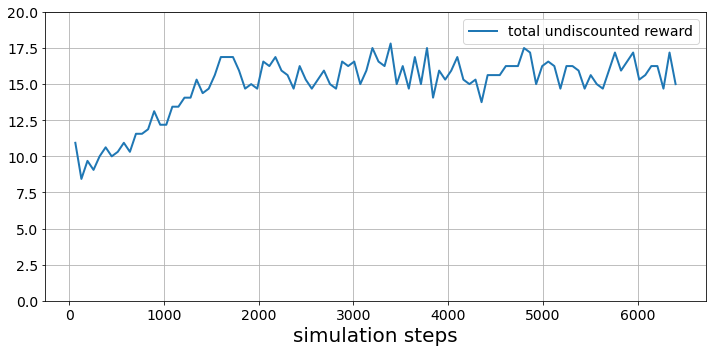

In [34]:
theta = torch.tensor(rg.standard_normal(size=(env.num_states, env.num_actions)), requires_grad=True)
print(f'\ntheta = {theta.detach().numpy().tolist()}\n')

alpha = 0.1
N = 32

data = {
    'step': [],
    'total_reward': [],
}
step = 0
for outer_iter in range(100):
    with torch.no_grad():
        batch_s = []
        batch_a = []
        batch_w = []
        r_total_average = 0
        for inner_iter in range(N):
            traj_s = []
            traj_a = []
            traj_r = []
            s = env.reset()
            while True:
                logits = theta[s]
                dist = torch.distributions.categorical.Categorical(logits=logits)
                a = dist.sample().item()
                s_prime, r, done = env.step(a)
                traj_s.append(s)
                traj_a.append(a)
                traj_r.append(r)
                s = s_prime
                if done:
                    break
            batch_s.extend(traj_s)
            batch_a.extend(traj_a)
            batch_w.extend([np.sum(traj_r)] * len(traj_r))
            r_total_average += np.sum(traj_r)
        r_total_average /= N
    
    step += N * env.max_num_steps
    data['step'].append(step)
    data['total_reward'].append(r_total_average)
    if (outer_iter + 1) % 10 == 0:
        print(f'{step} : {r_total_average}')
    
    # Convert each batch from list to tensor
    batch_s = torch.tensor(batch_s, requires_grad=False)
    batch_a = torch.tensor(batch_a, requires_grad=False)
    batch_w = torch.tensor(batch_w, requires_grad=False)
            
    # Update weights
    # - zero any gradient information in theta (very important - gradients are accumulated)
    if theta.grad is not None:
        theta.grad.zero_()
    # - do autodifferentiation
    logits = theta[batch_s]
    dist = torch.distributions.categorical.Categorical(logits=logits)
    loss = (env.max_num_steps * dist.log_prob(batch_a) * batch_w).mean()
    loss.backward()
    # - take ascent step
    with torch.no_grad():
        theta += alpha * theta.grad
    # # - alternative (in this case, would not require zeroing the gradient - be careful!):
    # with torch.no_grad():
    #     theta = theta + alpha * theta.grad
    # theta.requires_grad = True

print(f'\ntheta = {theta.detach().numpy().tolist()}\n')
print(policy_as_string(theta))

plot_learning_curve(data)

Implementation with an optimizer


theta = [[1.0040352435327338, 0.48051821371939374], [-1.39668968313574, -0.4401986880486743]]

640 : 14.375
1280 : 16.5625
1920 : 16.5625
2560 : 16.5625
3200 : 16.25
3840 : 17.1875
4480 : 16.25
5120 : 15.3125
5760 : 15.625
6400 : 16.875

theta = [[3.5443763449556323, -2.0598228877035023], [-3.7834839130261555, 1.9465955418417404]]

greedy policy:
 pi(0) = 0
 pi(1) = 1



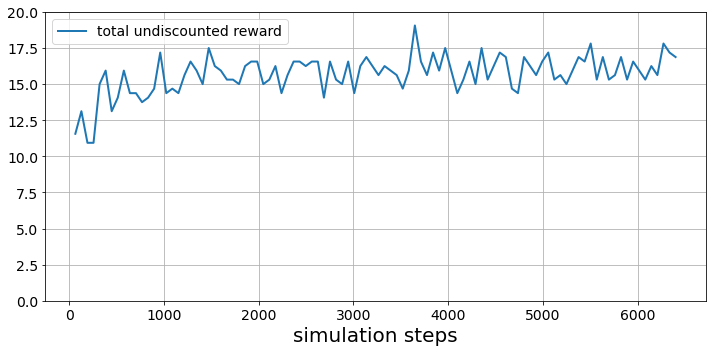

In [33]:
theta = torch.tensor(rg.standard_normal(size=(env.num_states, env.num_actions)), requires_grad=True)
print(f'\ntheta = {theta.detach().numpy().tolist()}\n')

alpha = 0.1
N = 32

optimizer = torch.optim.Adam([theta], lr=alpha) # <-- note how we need to pass parameters to the
                                                #     optimizer if they are defined by hand

data = {
    'step': [],
    'total_reward': [],
}
step = 0
for outer_iter in range(100):
    with torch.no_grad():
        batch_s = []
        batch_a = []
        batch_w = []
        r_total_average = 0
        for inner_iter in range(N):
            traj_s = []
            traj_a = []
            traj_r = []
            s = env.reset()
            while True:
                logits = theta[s]
                dist = torch.distributions.categorical.Categorical(logits=logits)
                a = dist.sample().item()
                s_prime, r, done = env.step(a)
                traj_s.append(s)
                traj_a.append(a)
                traj_r.append(r)
                s = s_prime
                if done:
                    break
            batch_s.extend(traj_s)
            batch_a.extend(traj_a)
            batch_w.extend([np.sum(traj_r)] * len(traj_r))
            r_total_average += np.sum(traj_r)
        r_total_average /= N
    
    step += N * env.max_num_steps
    data['step'].append(step)
    data['total_reward'].append(r_total_average)
    if (outer_iter + 1) % 10 == 0:
        print(f'{step} : {r_total_average}')
    
    # Convert each batch from list to tensor
    batch_s = torch.tensor(batch_s, requires_grad=False)
    batch_a = torch.tensor(batch_a, requires_grad=False)
    batch_w = torch.tensor(batch_w, requires_grad=False)
            
    # Update weights
    optimizer.zero_grad()
    logits = theta[batch_s]
    dist = torch.distributions.categorical.Categorical(logits=logits)
    loss = - (env.max_num_steps * dist.log_prob(batch_a) * batch_w).mean()
    loss.backward()
    optimizer.step()

print(f'\ntheta = {theta.detach().numpy().tolist()}\n')
print(policy_as_string(theta))

plot_learning_curve(data)

## Extension 1: Baseline (for variance reduction)

The key idea is that while $\nabla_\theta J(\theta)$ and $\nabla_\theta \left( J(\theta) - b\right)$ are clearly the same for any constant $b$, our *estimate* of these two quantities for a fixed number of sampled trajectories may be different. In particular, the subtraction of a "baseline" $b$ may reduce the variance of the quantity to be estimated and so, on average, reduce the estimation error.

(Later on, we will see that $b$ does not have to be constant - this is the basis for some of the more advanced methods of policy gradient.)

First, for convenience, we define two functions that allow us to sample a batch of simulation steps using torch.

In [76]:
def action_torch(s, theta):
    logits = theta[s]
    dist = torch.distributions.categorical.Categorical(logits=logits)
    return dist.sample().item()

def get_batch_torch_baseline(N, theta):
    with torch.no_grad():
        batch = {'s': [], 'a': [], 'w': []}
        for i in range(N):
            s0 = env.reset()
            a0 = action_torch(s0, theta)
            s1, r0, _ = env.step(a0)
            a1 = action_torch(s1, theta)
            _, r1, _ = env.step(a1)
            batch['s'].extend([s0, s1])
            batch['a'].extend([a0, a1])
            batch['w'].extend( [r0 + r1, r0 + r1])
        return batch

Next, we reimplement the function that estimates the gradient of the payoff from a batch of simulation steps. Note that this function actually returns a list of gradients $\nabla_\theta \log p \left( a_t | s_t ; \theta \right)$, that is to say, a list of all the terms that are subsequently averaged to estimate the total gradient. The reason we do this is so that we can look at how the estimate converges with the number of steps (i.e., the number of terms that are averaged). The variable `grad_without_baseline` contains estimates *without* a baseline. The variable `grad_with_baseline` contains estimates *with* a baseline.

In [77]:
def get_gradients_baseline(batch, theta):
    b = np.mean(batch['w']) # <--- average reward - this is our "baseline"
    grad_without_baseline = []
    grad_with_baseline = []
    for (s, a, w) in zip(batch['s'], batch['a'], batch['w']):
        grad_without_baseline.append((action_log_probability_gradient(a, s, theta) * w).reshape(-1))
        grad_with_baseline.append((action_log_probability_gradient(a, s, theta) * (w - b)).reshape(-1))
    return np.array(grad_without_baseline).T, np.array(grad_with_baseline).T

Here are the results.

Notice from the plots that the estimation error converges more quickly with a baseline.

Notice from the text that the sample mean is about the same with and without a baseline, but that the standard deviation with a baseline goes down


theta[0, 0] :  1.532 : without baseline mean  1.601 std 10.264 : with baseline mean  1.542 std  4.195
theta[0, 1] : -1.532 : without baseline mean -1.601 std 10.264 : with baseline mean -1.542 std  4.195
theta[1, 0] : -0.867 : without baseline mean -0.838 std 5.213 : with baseline mean -0.872 std  4.537
theta[1, 1] :  0.867 : without baseline mean  0.838 std 5.213 : with baseline mean  0.872 std  4.537



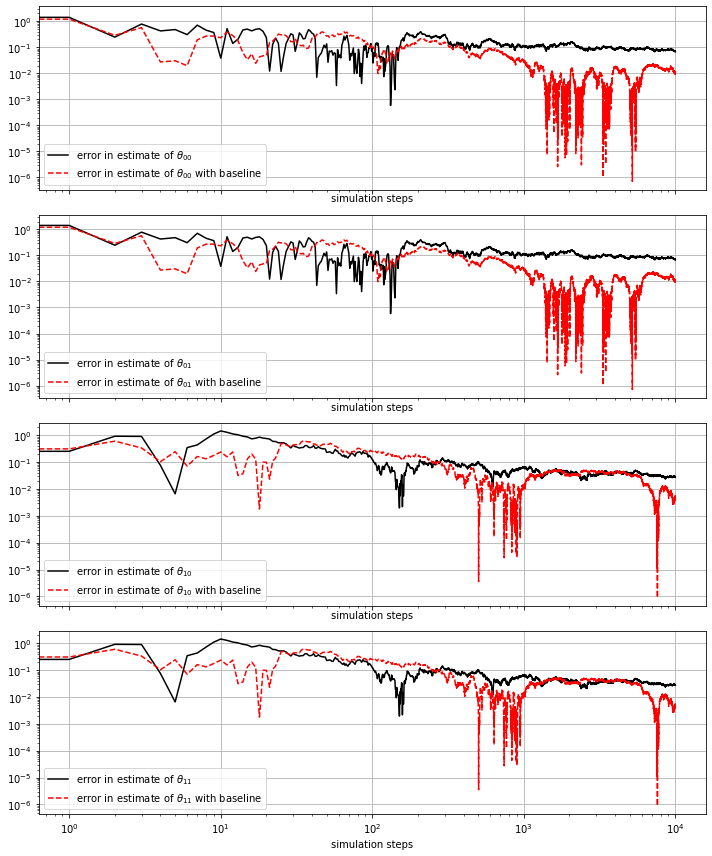

In [102]:
# Number of runs
M = 10

# Number of episodes per run
N = 5_000

theta = rg.standard_normal(size=(env.num_states, env.num_actions))
# theta = np.zeros((env.num_states, env.num_actions))

grad_exact = payoff_gradient_with_log(theta).reshape(-1)

mu_no = []
mu_yes = []

std_no = []
std_yes = []

for iter in range(M):
    batch = get_batch_torch_baseline(N, torch.tensor(theta))
    grad_no, grad_yes = get_gradients_baseline(batch, theta)
    mu_no.append(np.cumsum(grad_no, axis=1) * env.max_num_steps / (1 + np.arange(2 * N)))
    mu_yes.append(np.cumsum(grad_yes, axis=1) * env.max_num_steps / (1 + np.arange(2 * N)))
    std_no.append(np.std(grad_no * env.max_num_steps, axis=1))
    std_yes.append(np.std(grad_yes * env.max_num_steps, axis=1))

mu_no = np.array(mu_no).mean(axis=0)
mu_yes = np.array(mu_yes).mean(axis=0)
std_no = np.array(std_no).mean(axis=0)
std_yes = np.array(std_yes).mean(axis=0)

print('')
fig, ax = plt.subplots(4, 1, figsize=(10, 12), sharex=True)
for i in range(4):
    s = i // 2
    a = i % 2
    ax[i].loglog(np.abs(mu_no[i] - grad_exact[i]), label=f'error in estimate of $\\theta_{{ {s}{a} }}$', linestyle='-', color='k')
    ax[i].loglog(np.abs(mu_yes[i] - grad_exact[i]), label=f'error in estimate of $\\theta_{{ {s}{a} }}$ with baseline', linestyle='--', color='r')
    ax[i].grid()
    ax[i].legend()
    ax[i].set_xlabel('simulation steps')
    print(f'theta[{s}, {a}] : {grad_exact[i]:6.3f} : without baseline mean {mu_no[i, -1]:6.3f} std {std_no[i]:5.3f} : with baseline mean {mu_yes[i, -1]:6.3f} std {std_yes[i]:6.3f}')
plt.tight_layout()
print('')

## Extension 2: Causality (for variance reduction)

The key idea is that the action taken at the current time step has no impact on reward obtained at previous time steps. In particular, for the simple example, the following expression is true:
$$E_{\tau \sim p(\tau ; \theta)}\biggl[ \nabla_\theta \log p\left( a_1 | s_1 ; \theta \right) r\left(s_0, a_0\right) \biggr] = 0$$
It is silly to estimate a quantity that we know to be zero, because it adds variance without changing the mean. "Causality" means we drop this term from our estimate.

We reimplement the function that samples the batch - adding a weight that takes "causality" into account - and also the function the computes gradients.

In [79]:
def get_batch_torch_causality(N, theta):
    with torch.no_grad():
        batch = {'s': [], 'a': [], 'w': [], 'w_with_causality': []}
        for i in range(N):
            s0 = env.reset()
            a0 = action_torch(s0, theta)
            s1, r0, _ = env.step(a0)
            a1 = action_torch(s1, theta)
            _, r1, _ = env.step(a1)
            batch['s'].extend([s0, s1])
            batch['a'].extend([a0, a1])
            batch['w'].extend(                [r0 + r1, r0 + r1])
            batch['w_with_causality'].extend( [r0 + r1,      r1]) # <--- this is the change with "causality"
        return batch

def get_gradients_causality(batch, theta):
    grad_without_causality = []
    grad_with_causality = []
    for (s, a, w, wc) in zip(batch['s'], batch['a'], batch['w'], batch['w_with_causality']):
        grad_without_causality.append((action_log_probability_gradient(a, s, theta) * w).reshape(-1))
        grad_with_causality.append((action_log_probability_gradient(a, s, theta) * wc).reshape(-1))
    return np.array(grad_without_causality).T, np.array(grad_with_causality).T

Here are the results.

Notice from the plots that the estimation error converges more quickly with causality.

Notice from the text that the sample mean is about the same with and without causality, but that the standard deviation with causality goes down


theta[0, 0] :  1.505 : without causality mean  1.493 std 8.403 : with causality mean  1.493 std  5.968
theta[0, 1] : -1.505 : without causality mean -1.493 std 8.403 : with causality mean -1.493 std  5.968
theta[1, 0] : -0.470 : without causality mean -0.475 std 4.341 : with causality mean -0.475 std  4.341
theta[1, 1] :  0.470 : without causality mean  0.475 std 4.341 : with causality mean  0.475 std  4.341



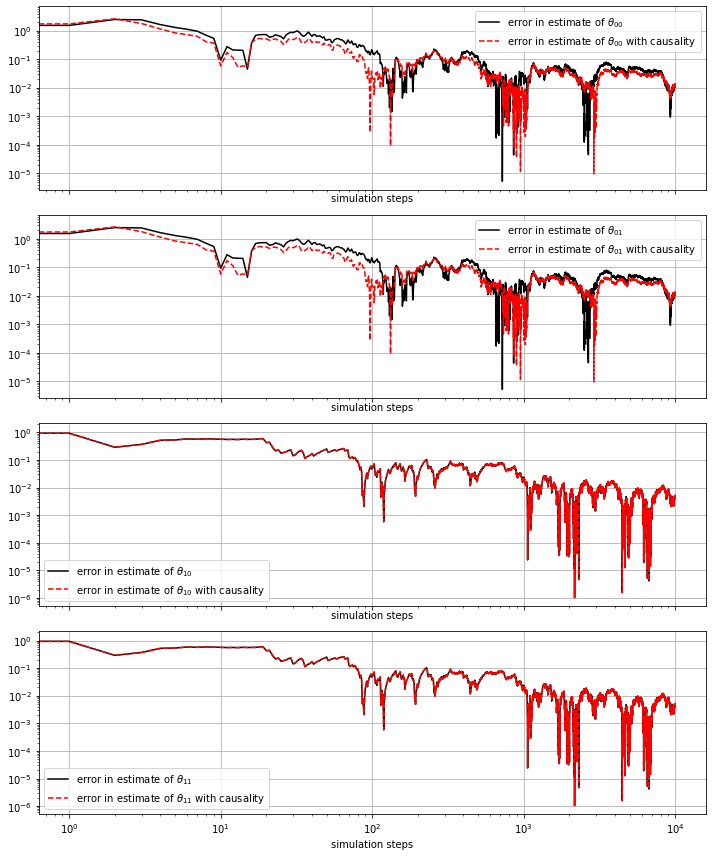

In [103]:
# Number of runs
M = 10

# Number of episodes per run
N = 5_000

theta = rg.standard_normal(size=(env.num_states, env.num_actions))
# theta = np.zeros((env.num_states, env.num_actions))

grad_exact = payoff_gradient_with_log(theta).reshape(-1)

mu_no = []
mu_yes = []

std_no = []
std_yes = []

for iter in range(M):
    batch = get_batch_torch_causality(N, torch.tensor(theta))
    grad_no, grad_yes = get_gradients_causality(batch, theta)
    mu_no.append(np.cumsum(grad_no, axis=1) * env.max_num_steps / (1 + np.arange(2 * N)))
    mu_yes.append(np.cumsum(grad_yes, axis=1) * env.max_num_steps / (1 + np.arange(2 * N)))
    std_no.append(np.std(grad_no * env.max_num_steps, axis=1))
    std_yes.append(np.std(grad_yes * env.max_num_steps, axis=1))

mu_no = np.array(mu_no).mean(axis=0)
mu_yes = np.array(mu_yes).mean(axis=0)
std_no = np.array(std_no).mean(axis=0)
std_yes = np.array(std_yes).mean(axis=0)

print('')
fig, ax = plt.subplots(4, 1, figsize=(10, 12), sharex=True)
for i in range(4):
    s = i // 2
    a = i % 2
    ax[i].loglog(np.abs(mu_no[i] - grad_exact[i]), label=f'error in estimate of $\\theta_{{ {s}{a} }}$', linestyle='-', color='k')
    ax[i].loglog(np.abs(mu_yes[i] - grad_exact[i]), label=f'error in estimate of $\\theta_{{ {s}{a} }}$ with causality', linestyle='--', color='r')
    ax[i].grid()
    ax[i].legend()
    ax[i].set_xlabel('simulation steps')
    print(f'theta[{s}, {a}] : {grad_exact[i]:6.3f} : without causality mean {mu_no[i, -1]:6.3f} std {std_no[i]:5.3f} : with causality mean {mu_yes[i, -1]:6.3f} std {std_yes[i]:6.3f}')
plt.tight_layout()
print('')

## Extension 3: Importance sampling (for off-policy learning)

The key idea is that if we weight gradient terms by a log-likelihood ratio - representing how much more likely the corresponding action is under the current policy than under the policy that was used to generate the action - then we can use simulation steps generated under old policies. That is, we can enable off-policy learning.

We reimplement the function that samples the batch - adding the log-likelihood of the action under the policy that was used to simulate it - and also the function the computes gradients.

In [104]:
def get_batch_torch_IS(N, theta):
    with torch.no_grad():
        batch = {'s': [], 'a': [], 'w': [], 'log_pi': []}
        for i in range(N):
            s0 = env.reset()
            a0 = action_torch(s0, theta)
            s1, r0, _ = env.step(a0)
            a1 = action_torch(s1, theta)
            _, r1, _ = env.step(a1)
            batch['s'].extend([s0, s1])
            batch['a'].extend([a0, a1])
            batch['w'].extend([r0 + r1, r0 + r1])
            log_pi_0 = action_log_probability(a0, s0, theta.numpy())
            log_pi_1 = action_log_probability(a1, s1, theta.numpy())
            batch['log_pi'].extend([log_pi_0, log_pi_1])
        return batch

def get_gradients_IS(batch, theta):
    grad_without_IS = []
    grad_with_IS = []
    for (s, a, w, old_log_pi) in zip(batch['s'], batch['a'], batch['w'], batch['log_pi']):
        log_pi = action_log_probability(a, s, theta)
        ratio = np.exp(log_pi - old_log_pi)
        grad_without_IS.append((action_log_probability_gradient(a, s, theta) * w).reshape(-1))
        grad_with_IS.append((action_log_probability_gradient(a, s, theta) * w * ratio).reshape(-1))
    return np.array(grad_without_IS).T, np.array(grad_with_IS).T

Here are the results.

We have used one policy $\theta_\text{old}$ to sample trajectories. Then, we have used a different policy $\theta$ to compute gradients. The key thing to note is that gradient estimates are *terrible* without importance sampling.

(Variance may be more, less, or the same with importance sampling, depending on the run and on the values chosen for $\theta_\text{old}$ and $\theta$.)

old_theta = [[0.0, 0.0], [0.0, 0.0]]
    theta = [[2.464341327530459, -0.33257384344076807], [-1.4062907380047134, 0.9269559839612007]]

theta[0, 0] :  0.411 : without IS mean -4.171 std 9.919 : with IS mean  0.315 std  2.161
theta[0, 1] : -0.411 : without IS mean  4.171 std 9.919 : with IS mean -0.315 std  2.161
theta[1, 0] : -0.364 : without IS mean  1.736 std 6.881 : with IS mean -0.453 std  2.255
theta[1, 1] :  0.364 : without IS mean -1.736 std 6.881 : with IS mean  0.453 std  2.255



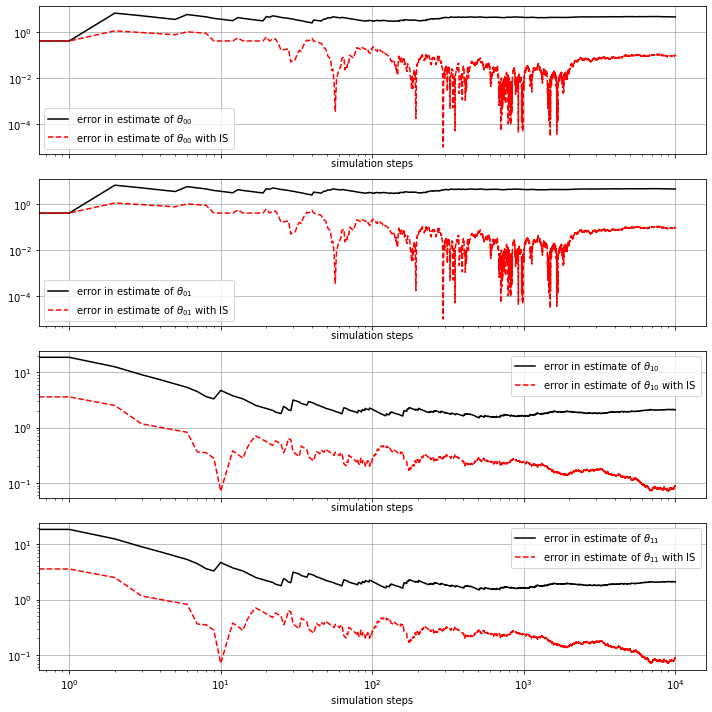

In [116]:
# Number of episodes (we only do one run)
N = 5_000

# The policy used for simulation
old_theta = np.zeros((env.num_states, env.num_actions))
# old_theta = rg.standard_normal(size=(env.num_states, env.num_actions))

# The policy used for gradient estimation
delta = 1.0
theta = old_theta + delta * rg.standard_normal(size=(env.num_states, env.num_actions))

batch = get_batch_torch_IS(N, torch.tensor(old_theta))

print(f'old_theta = {old_theta.tolist()}')
print(f'    theta = {theta.tolist()}')

grad_exact = payoff_gradient_with_log(theta).reshape(-1)
grad_no, grad_yes = get_gradients_IS(batch, theta)
mu_no = np.cumsum(grad_no, axis=1) * env.max_num_steps / (1 + np.arange(2 * N))
mu_yes = np.cumsum(grad_yes, axis=1) * env.max_num_steps / (1 + np.arange(2 * N))
std_no = np.std(grad_no * env.max_num_steps, axis=1)
std_yes = np.std(grad_yes * env.max_num_steps, axis=1)

print('')
fig, ax = plt.subplots(4, 1, figsize=(10, 10), sharex=True)
for i in range(4):
    s = i // 2
    a = i % 2
    ax[i].loglog(np.abs(mu_no[i] - grad_exact[i]), label=f'error in estimate of $\\theta_{{ {s}{a} }}$', linestyle='-', color='k')
    ax[i].loglog(np.abs(mu_yes[i] - grad_exact[i]), label=f'error in estimate of $\\theta_{{ {s}{a} }}$ with IS', linestyle='--', color='r')
    ax[i].grid()
    ax[i].legend()
    ax[i].set_xlabel('simulation steps')
    print(f'theta[{s}, {a}] : {grad_exact[i]:6.3f} : without IS mean {mu_no[i, -1]:6.3f} std {std_no[i]:5.3f} : with IS mean {mu_yes[i, -1]:6.3f} std {std_yes[i]:6.3f}')
plt.tight_layout()
print('')

The key reason that off-policy learning is so critical for policy gradient methods is that it allows us to take many gradient descent steps based on the same set of simulated trajectories.

Without importance sampling, we *must* take only *one* gradient descent step - otherwise, as we've seen in the results above, we would be using a terrible gradient estimate.

With importance sampling, we can take *many* gradient descent steps. See below for an implementation with the simple example in which we take 10 gradient descent steps for each batch of trajectories. For real-world problems we might take many more gradient descent steps - 80 gradient descent steps per 4000 simulation steps, for example, would not be uncommon.

I cannot emphasize enough how critical this is for policy gradient methods to work in practice!


theta = [[1.8588616527677657, 0.15001698689879958], [-1.2450051516910032, 0.8509254702816144]]

640 : 16.875
1280 : 15.9375
1920 : 16.5625
2560 : 17.1875
3200 : 16.875
3840 : 16.5625
4480 : 16.5625
5120 : 14.6875
5760 : 15.3125
6400 : 15.625

theta = [[5.928580004807753, -3.9197013651414676], [-5.891227232323666, 5.497147550914347]]

greedy policy:
 pi(0) = 0
 pi(1) = 1



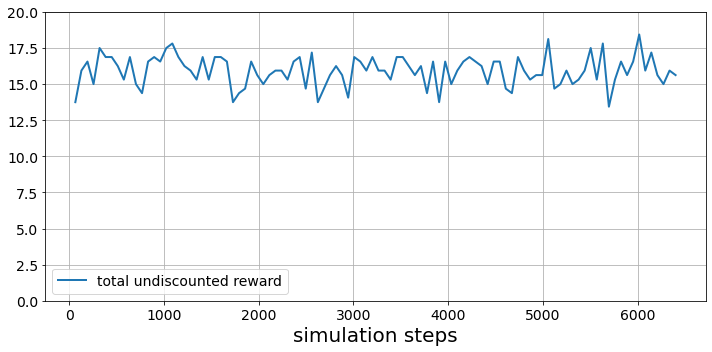

In [123]:
theta = torch.tensor(rg.standard_normal(size=(env.num_states, env.num_actions)), requires_grad=True)
print(f'\ntheta = {theta.detach().numpy().tolist()}\n')

alpha = 0.1
N = 32

optimizer = torch.optim.Adam([theta], lr=alpha)

data = {
    'step': [],
    'total_reward': [],
}
step = 0
for outer_iter in range(100):
    with torch.no_grad():
        batch_s = []
        batch_a = []
        batch_w = []
        batch_log_pi = []
        r_total_average = 0
        for inner_iter in range(N):
            traj_s = []
            traj_a = []
            traj_r = []
            traj_log_pi = []
            s = env.reset()
            while True:
                a = action_torch(s, theta)
                s_prime, r, done = env.step(a)
                traj_s.append(s)
                traj_a.append(a)
                traj_r.append(r)
                traj_log_pi.append(action_log_probability(a, s, theta.numpy()))
                s = s_prime
                if done:
                    break
            batch_s.extend(traj_s)
            batch_a.extend(traj_a)
            batch_w.extend([np.sum(traj_r)] * len(traj_r))
            batch_log_pi.extend(traj_log_pi)
            r_total_average += np.sum(traj_r)
        r_total_average /= N
    
    step += N * env.max_num_steps
    data['step'].append(step)
    data['total_reward'].append(r_total_average)
    if (outer_iter + 1) % 10 == 0:
        print(f'{step} : {r_total_average}')
    
    # Convert each batch from list to tensor
    batch_s = torch.tensor(batch_s, requires_grad=False)
    batch_a = torch.tensor(batch_a, requires_grad=False)
    batch_w = torch.tensor(batch_w, requires_grad=False)
    batch_log_pi = torch.tensor(batch_log_pi, requires_grad=False)
            
    # Update weights... many times! <-- THIS IS WHAT IMPORTANCE SAMPLING BUYS US
    #
    #     (Why stop at 10 updates? What about 100? Or 1000? What would happen?)
    #
    for epoch in range(10):
        optimizer.zero_grad()
        logits = theta[batch_s]
        dist = torch.distributions.categorical.Categorical(logits=logits)
        with torch.no_grad():
            log_pi = dist.log_prob(batch_a)
            ratio = torch.exp(log_pi - batch_log_pi)
        loss = - (env.max_num_steps * dist.log_prob(batch_a) * batch_w * ratio).mean()
        loss.backward()
        optimizer.step()

print(f'\ntheta = {theta.detach().numpy().tolist()}\n')
print(policy_as_string(theta))

plot_learning_curve(data)

## Advantage function estimation

In [ ]:
def get_batch_torch_gae(N, theta):
    with torch.no_grad():
        batch = {'s': [], 'a': [], 'w': [], 'log_pi': []}
        for i in range(N):
            s0 = env.reset()
            a0 = action_torch(s0, theta)
            s1, r0, _ = env.step(a0)
            a1 = action_torch(s1, theta)
            _, r1, _ = env.step(a1)
            batch['s'].extend([s0, s1])
            batch['a'].extend([a0, a1])
            batch['w'].extend([r0 + r1, r0 + r1])
            log_pi_0 = action_log_probability(a0, s0, theta.numpy())
            log_pi_1 = action_log_probability(a1, s1, theta.numpy())
            batch['log_pi'].extend([log_pi_0, log_pi_1])
        return batch

def get_gradients_IS(batch, theta):
    grad_without_IS = []
    grad_with_IS = []
    for (s, a, w, old_log_pi) in zip(batch['s'], batch['a'], batch['w'], batch['log_pi']):
        log_pi = action_log_probability(a, s, theta)
        ratio = np.exp(log_pi - old_log_pi)
        grad_without_IS.append((action_log_probability_gradient(a, s, theta) * w).reshape(-1))
        grad_with_IS.append((action_log_probability_gradient(a, s, theta) * w * ratio).reshape(-1))
    return np.array(grad_without_IS).T, np.array(grad_with_IS).T

# Gridworld example

Import the simple_example module, reloading it so we are sure to get any changes

In [124]:
import gridworld
importlib.reload(gridworld)

<module 'gridworld' from '/Users/timothybretl/Documents/courses/598RL/02_Fall2020/598rl-fa20/lecture_notes/12_policygradient/gridworld.py'>

Create a random number generator and an instance of the simple_example environment

In [125]:
rg = np.random.default_rng()
env = gridworld.GridWorld()

## Exact gradient

Things we need to compute the exact payoff gradient

In [126]:
def action_probability(a, s, theta):
    return np.exp(theta[a, s]) / np.exp(theta[:, s]).sum()

def action_probability_gradient(a, s, theta):
    theta_t = torch.tensor(theta, requires_grad=True)
    p_t = torch.exp(theta_t[a, s]) / torch.exp(theta_t[:, s]).sum()
    p_t.backward()
    return theta_t.grad.numpy()

def trajectory_probability_gradient(tau, theta):
    grad = np.zeros_like(theta)
    for t in range(env.max_num_steps - 1):
        st = tau[2 * t]
        at = tau[2 * t + 1]
        stplus1 = tau[2 * t + 2]
        grad_inner = action_probability_gradient(at, st, theta)
        if t != env.max_num_steps - 1:
            grad_inner *= env.p(stplus1, st, at)
        for k in range(env.max_num_steps - 1):
            sk = tau[2 * k]
            ak = tau[2 * k + 1]
            skplus1 = tau[2 * k + 2]
            if k != t:
                grad_inner *= action_probability(ak, sk, theta)
                if k != env.max_num_steps - 1:
                    grad_inner *= env.p(skplus1, sk, ak)
        grad += grad_inner
    return grad

def total_reward(tau):
    r = 0
    for i in range(env.max_num_steps):
        s = tau[2 * i]
        a = tau[2 * i + 1]
        r += env.r(s, a)
    return r

In [127]:
theta = rg.standard_normal(size=(env.num_actions, env.num_states))

In [128]:
tau = []
for i in range(env.max_num_steps):
#     # random trajectory (almost certainly infeasible)
#     tau.append(rg.integers(env.num_states))
#     tau.append(rg.integers(env.num_actions))
#     # constant trajectory (feasible but extremely unlikely)
#     tau.append(0)   # top left corner
#     tau.append(1)   # try to move up
    # trajectory from random policy (feasible but unlikely)
    if (i == 0):
        tau.append(env.reset())
    else:
        s, r, done = env.step(tau[-1])
        tau.append(s)
    tau.append(rg.integers(env.num_actions))

print(f'tau = {tau}')
print(f'grad p(tau ; theta) = {trajectory_probability_gradient(tau, theta)}')
print(f'total_reward = {total_reward(tau)}')

tau = [16, 2, 15, 2, 15, 3, 20, 0, 21, 3, 21, 1, 16, 1, 11, 0, 12, 3, 17, 0, 18, 0, 19, 2, 18, 0, 19, 3, 24, 1, 19, 2, 18, 3, 23, 3, 23, 3, 23, 0, 24, 1, 19, 0, 19, 2, 18, 3, 23, 0, 24, 3, 24, 0, 24, 1, 19, 3, 24, 3, 24, 3, 24, 1, 19, 3, 24, 3, 24, 3, 24, 0, 24, 0, 24, 2, 23, 2, 22, 2, 21, 0, 22, 3, 22, 1, 17, 2, 16, 0, 17, 0, 18, 3, 23, 3, 23, 0, 24, 0, 24, 2, 23, 1, 18, 0, 19, 2, 18, 0, 19, 3, 24, 2, 23, 3, 23, 3, 23, 1, 18, 0, 19, 2, 18, 2, 17, 2, 16, 1, 11, 3, 16, 1, 11, 0, 12, 0, 13, 1, 8, 2, 7, 3, 12, 1, 7, 2, 6, 1, 1, 2, 21, 2, 20, 1, 15, 0, 16, 2, 15, 0, 16, 1, 11, 1, 6, 3, 11, 2, 10, 2, 10, 1, 5, 0, 6, 2, 5, 0, 6, 2, 5, 0, 6, 2, 5, 2, 5, 1, 0, 2, 0, 0, 1, 3, 21, 1, 16, 0]
grad p(tau ; theta) = [[ 3.55971867e-75 -5.73720622e-76  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.00216168e-74 -2.94021776e-75 -5.80924286e-75
  -2.44690463e-76  0.00000000e+00 -1.53109283e-75 -4.65938828e-75
   1.79978875e-75 -2.25908773e-75  0.00000000e+00  4.79719050e-75
  -2.94567191e-75  2.325

Things we need to compute payoff gradient with log probabilities

In [129]:
def action_log_probability_gradient(a, s, theta):
    theta_t = torch.tensor(theta, requires_grad=True)
    p_t = theta_t[a, s] - torch.exp(theta_t[:, s]).sum().log()
    p_t.backward()
    return theta_t.grad.numpy()

def trajectory_log_probability_gradient(tau, theta):
    grad = 0
    for i in range(env.max_num_steps):
        s = tau[2 * i]
        a = tau[2 * i + 1]
        grad += action_log_probability_gradient(a, s, theta)
    return grad

In [130]:
tau = []
for i in range(env.max_num_steps):
#     # random trajectory (almost certainly infeasible)
#     tau.append(rg.integers(env.num_states))
#     tau.append(rg.integers(env.num_actions))
#     # constant trajectory (feasible but extremely unlikely)
#     tau.append(0)   # top left corner
#     tau.append(1)   # try to move up
    # trajectory from random policy (feasible but unlikely)
    if (i == 0):
        tau.append(env.reset())
    else:
        s, r, done = env.step(tau[-1])
        tau.append(s)
    tau.append(rg.integers(env.num_actions))

print(f'tau = {tau}')
print(f'grad p(tau ; theta) = {trajectory_probability_gradient(tau, theta)}')
print(f'grad log p(tau ; theta) = {trajectory_log_probability_gradient(tau, theta)}')
print(f'total_reward = {total_reward(tau)}')

tau = [1, 3, 21, 0, 22, 3, 22, 3, 22, 3, 22, 0, 23, 2, 22, 3, 22, 3, 22, 0, 23, 1, 18, 1, 13, 0, 14, 2, 13, 0, 14, 2, 13, 2, 12, 3, 17, 1, 12, 0, 13, 1, 8, 2, 7, 0, 8, 0, 9, 2, 8, 3, 13, 2, 12, 0, 13, 2, 12, 2, 11, 3, 16, 2, 15, 0, 16, 1, 11, 2, 10, 1, 5, 0, 6, 1, 1, 2, 21, 1, 16, 1, 11, 3, 16, 3, 21, 0, 22, 0, 23, 1, 18, 1, 13, 3, 18, 0, 19, 1, 14, 3, 19, 0, 19, 3, 24, 1, 19, 0, 19, 1, 14, 1, 9, 3, 14, 3, 19, 0, 19, 1, 14, 1, 9, 3, 14, 1, 9, 0, 9, 1, 4, 1, 4, 3, 9, 3, 14, 1, 9, 1, 4, 1, 4, 1, 4, 2, 3, 3, 13, 2, 12, 3, 17, 2, 16, 1, 11, 2, 10, 0, 11, 3, 16, 1, 11, 2, 10, 3, 15, 2, 15, 1, 10, 2, 10, 2, 10, 0, 11, 2, 10, 0, 11, 2, 10, 1, 5, 1, 0, 1, 0, 2, 0, 1, 0, 3, 5, 2]
grad p(tau ; theta) = [[-2.16410577e-78 -2.39271526e-78  0.00000000e+00 -3.31711110e-78
  -6.47485419e-78  1.35325663e-77 -2.45244937e-78  3.81415122e-78
   1.28664809e-77 -3.97991148e-77  2.22419946e-77 -8.20607572e-77
   1.78194160e-77 -4.35167399e-77 -6.36451047e-77  7.04112492e-78
  -2.41825168e-77 -1.10796141e-77 